# RL - Assignement - Text Flappy Bird

## Packages

In [2]:
# Third party imports
import os
import sys
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.stats import sem
from tqdm import tqdm
from collections import defaultdict

# Local imports
import gymnasium as gym
from mpl_toolkits.mplot3d import axes3d
from utils.plot_utils import plot_state_values, plot_policy

import text_flappy_bird_gym
from models.base_agent import BaseAgent

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

## Environment

In [3]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_scores = {} # Contains the scores obtained for each run
agent_info = {"num_actions": 2, "epsilon": 0.1, "epsilon_decay":.999, "step_size": 0.1, "step_size_decay": 0.9999, "discount": 1.0, "seed":42}
agent_info["policy"] = None
env_info = {}

## Agent 1: Expected SARSA

In [4]:
from expected_sarsa import ExpectedSarsaAgent

In [5]:
agent = ExpectedSarsaAgent(agent_info)
all_reward_sums["expected_sarsa"] = []
all_state_visits["expected_sarsa"] = []
all_scores["expected_sarsa"] = []

action = agent.agent_start((0,0))
print("Action Value Estimates: \n", agent.q)
print("Action:", action)

Action Value Estimates: 
 {(0, 0): {0: 0, 1: 0}}
Action: 0


### Training

In [44]:

NUM_RUNS = 10000 # The number of runs
NUM_EPISODES = 500 # The number of episodes in each run

# Iteration over the number of runs
for run in tqdm(range(NUM_RUNS)):

    # Set the seed value to the current run index
    agent_info["seed"] = run

    # Initialize the environment
    # Returns (obs: (x_dist,y_dist), info: {"score", "player", "distance"})
    state, info = env.reset()

    # Set done to False
    done = False

    reward_sums = []
    state_visits = {}

    # Iterate over the number of episodes
    for episode in range(NUM_EPISODES):
        if episode == 0:
      
            # Keep track of the visited states
            state, info = env.reset()
            action = agent.agent_start(state)

            state_visits[state] = 1
            state, reward, done, _, info = env.step(action)
            reward_sums.append(reward)

        else:
            while not done:
              action = agent.agent_step(reward, state)

              if state not in state_visits: 
                  state_visits[state] = 1
              else:
                  state_visits[state] += 1

              state, reward, done, _, info = env.step(action)
              reward_sums.append(reward)

              # If terminal state
              if done:
                action = agent.agent_end(reward)
                break

    all_reward_sums["expected_sarsa"].append(np.sum(reward_sums))
    all_state_visits["expected_sarsa"].append(state_visits)
    all_scores["expected_sarsa"].append(info["score"])

    # Print the average reward sum & average score for the last 10 episodes
    if run % 1000 == 0:
        print("Run: ", run, "Average Reward Sum: ", np.mean(all_reward_sums["expected_sarsa"][-10:]))
        print("Run: ", run, "Average Score: ", np.mean(all_scores["expected_sarsa"][-10:]))

# Save policy for simulation
with open('expected_sarsa_q_values.pickle', 'wb') as handle:
    pickle.dump(agent.q, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save results for vizualization
with open('expected_sarsa_results.pickle', 'wb') as handle:
    pickle.dump(agent.q, handle, protocol=pickle.HIGHEST_PROTOCOL)


  2%|▏         | 224/10000 [00:00<00:16, 601.49it/s]

Run:  0 Average Reward Sum:  4.0
Run:  0 Average Score:  0.0


 11%|█         | 1088/10000 [00:01<00:12, 722.10it/s]

Run:  1000 Average Reward Sum:  8.5
Run:  1000 Average Score:  0.0


 21%|██        | 2068/10000 [00:03<00:16, 475.60it/s]

Run:  2000 Average Reward Sum:  19.6
Run:  2000 Average Score:  0.7


 31%|███       | 3054/10000 [00:06<00:29, 234.78it/s]

Run:  3000 Average Reward Sum:  27.5
Run:  3000 Average Score:  1.6


 40%|████      | 4045/10000 [00:12<00:44, 133.93it/s]

Run:  4000 Average Reward Sum:  57.8
Run:  4000 Average Score:  4.6


 50%|█████     | 5040/10000 [00:20<00:46, 106.91it/s]

Run:  5000 Average Reward Sum:  90.0
Run:  5000 Average Score:  7.9


 60%|██████    | 6025/10000 [00:30<00:47, 84.32it/s] 

Run:  6000 Average Reward Sum:  62.1
Run:  6000 Average Score:  4.9


 70%|███████   | 7017/10000 [00:41<00:28, 103.91it/s]

Run:  7000 Average Reward Sum:  76.0
Run:  7000 Average Score:  6.5


 80%|████████  | 8015/10000 [00:52<00:22, 89.74it/s] 

Run:  8000 Average Reward Sum:  55.7
Run:  8000 Average Score:  4.4


 90%|█████████ | 9019/10000 [01:09<00:11, 85.71it/s]

Run:  9000 Average Reward Sum:  93.1
Run:  9000 Average Score:  8.1


100%|██████████| 10000/10000 [01:24<00:00, 118.29it/s]


In [7]:
with open('./models/expected_sarsa_q_values.pickle', 'rb') as handle:
    q = pickle.load(handle)

In [9]:
q

{(0, 0): {0: 78.22308472165957, 1: 98.6280332668248},
 (13, -4): {0: 57.152386314719635, 1: 96.17373186200366},
 (12, -5): {0: 98.35214381971329, 1: 58.48409977579791},
 (11, -4): {0: 98.45331044230933, 1: 79.28958632559505},
 (10, -1): {0: 1.6199334204383478, 1: 99.2125229024188},
 (13, -3): {0: 96.90159784055508, 1: 66.74663096128491},
 (12, -3): {0: 71.30713697077586, 1: 98.24404532762755},
 (10, -3): {0: 91.42862274690214, 1: 99.76614094324904},
 (9, -4): {0: 97.5520264066694, 1: 99.22857661037062},
 (8, -5): {0: 98.26334113107765, 1: 95.13302932701589},
 (7, -4): {0: 97.360594900938, 1: 95.28314962855136},
 (6, -1): {0: 70.50042365970367, 1: 97.57387876120795},
 (5, -2): {0: 95.21959647846583, 1: 96.79853109012646},
 (4, -3): {0: 96.13099043340584, 1: 90.81648413094291},
 (3, -2): {0: 95.17823315155232, 1: 92.70458657136882},
 (2, -3): {0: 95.56336277691865, 1: 42.31895492352787},
 (1, -4): {0: 33.09945267503121, 1: 0.9997572505549683},
 (13, -1): {0: 95.64936137626259, 1: 62.0189

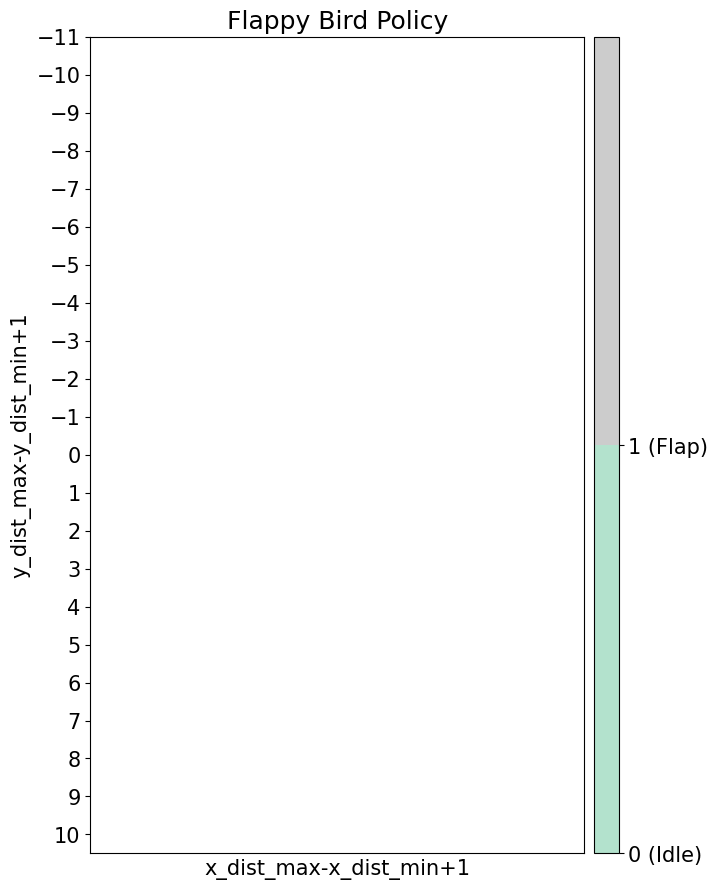

In [8]:
plot_policy(q)

## Agent 2: Deep Q-Learning

In [ ]:
import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Comparison

/var/folders/r7/nptln7p562l2yhwpxw1nxp880000gn/T/ipykernel_13440/3063769084.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad('gray')


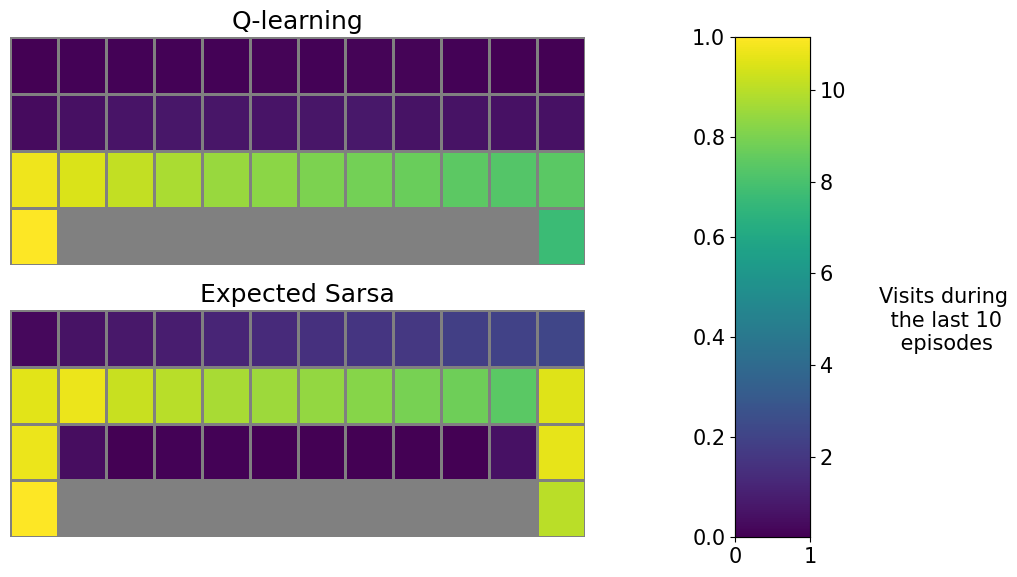

In [ ]:
# Do not modify this cell

for algorithm, position in [("Q-learning", 211), ("Expected Sarsa", 212)]:
    plt.subplot(position)
    average_state_visits = np.array(all_state_visits[algorithm]).mean(axis=0)
    grid_state_visits = average_state_visits.reshape((4,12))
    grid_state_visits[0,1:-1] = np.nan
    plt.pcolormesh(grid_state_visits, edgecolors='gray', linewidth=2)
    plt.title(algorithm)
    plt.axis('off')
    cm = plt.get_cmap()
    cm.set_bad('gray')

    plt.subplots_adjust(bottom=0.0, right=0.7, top=1.0)
    cax = plt.axes([0.85, 0.0, 0.075, 1.])
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel("Visits during\n the last 10\n episodes", rotation=0, labelpad=70)
plt.show()



Previously we used a fixed step-size of 0.5 for the agents. What happens with other step-sizes? Does this difference in performance persist?

In the next experiment we will try 10 different step-sizes from 0.1 to 1.0 and compare the sum of rewards per episode averaged over the first 100 episodes (similar to the interim performance curves in Figure 6.3 of the textbook). Shaded regions show standard errors.

This cell takes around 10 minutes to run. The result of this cell will be graded. If you make any changes to your algorithms, you have to run this cell again before submitting the assignment.

100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


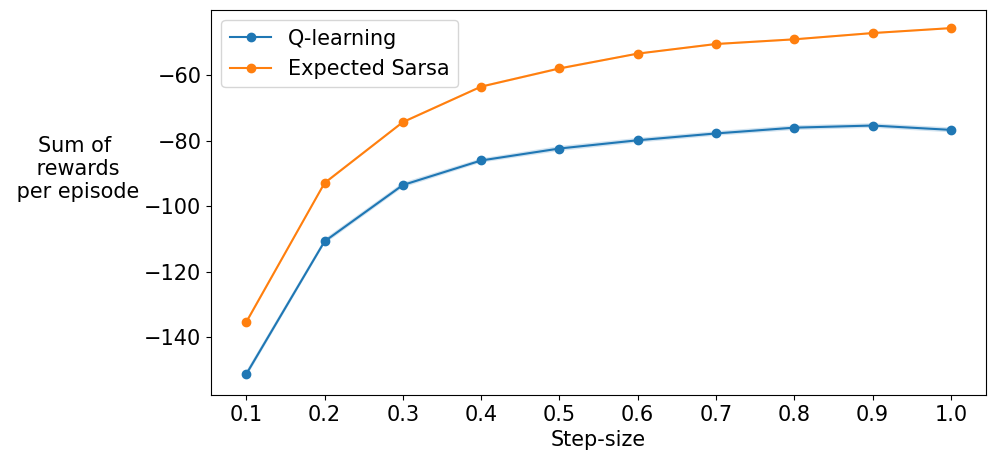

In [ ]:
# Do not modify this cell

agents = {
    "Q-learning": QLearningAgent,
    "Expected Sarsa": ExpectedSarsaAgent
}
env = cliffworld_env.Environment
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 100
all_reward_sums = {}

for algorithm in ["Q-learning", "Expected Sarsa"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            rl_glue = RLGlue(env, agents[algorithm])
            rl_glue.rl_init(agent_info, env_info)

            return_sum = 0
            for episode in range(num_episodes):
                rl_glue.rl_episode(0)
                return_sum += rl_glue.rl_return()
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

### Question:
Interpret the graph above.  

**Interpretations**:  
- Increasing the step-size improves the performance of the two algorithms in the Cliff Walking environment.
    - Until a certain threshold, where Q-learning stabilizes and starts to degrades slowly with the step-size getting bigger.
    - Expected Sarsa overcomes Q-Learning in any configuration.

Congratulations! Now you have:
- implemented MC control for BlackJack
- implemented Q-Learning with $\epsilon$-greedy action selection
- implemented Expected Sarsa with $\epsilon$-greedy action selection
- investigated the behavior of these last two algorithms on Cliff World

